# HeartGuard: ECG-Based Cardiovascular Risk Prediction System

## A Comprehensive AI System for Cardiac Risk Assessment

This notebook implements a complete cardiovascular risk prediction system using the PTB-XL dataset - the largest publicly available 12-lead ECG dataset with 21,799 clinical recordings.

### What This System Does:
1. **Analyzes ECG signals** - Processes 12-lead ECG recordings to detect cardiac abnormalities
2. **Predicts cardiac risk** - Uses machine learning to classify patients into risk categories
3. **Explains predictions** - Shows which ECG features drive the risk assessment
4. **Recommends interventions** - Provides personalized clinical recommendations

### Key Components:
- Deep learning models (CNN, CNN-LSTM) for ECG analysis
- Traditional ML (XGBoost) for comparison
- SHAP and GradCAM for model explainability
- Clinical intervention recommendation engine

---

# Section 1: Setup and Configuration

## What we're doing here:
This section sets up our working environment by:
1. **Installing required packages** - Libraries for ECG processing, machine learning, and visualization
2. **Importing all dependencies** - Loading the tools we'll use throughout
3. **Verifying GPU availability** - Ensuring we can use GPU acceleration for deep learning
4. **Setting up configuration** - Defining paths, hyperparameters, and constants

### Why this matters:
A proper setup ensures reproducibility and optimal performance. GPU acceleration is critical for training deep learning models efficiently on our RTX 3060 Ti.

In [1]:
# ============================================================================
# CORE IMPORTS
# ============================================================================

# Standard library
import os
import ast
import gc
import json
import warnings
from datetime import datetime
from collections import Counter

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# ECG file reading
import wfdb

# Signal processing
from scipy import signal
from scipy.stats import skew, kurtosis
from scipy.interpolate import interp1d

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning - Models and Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    accuracy_score, f1_score, cohen_kappa_score
)

# XGBoost
import xgboost as xgb

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Explainability
import shap

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

print("✓ All imports successful!")

c:\Users\Gebriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All imports successful!


In [3]:
# ============================================================================
# CONFIGURATION DICTIONARY
# ============================================================================

# This dictionary contains all configurable parameters for the project.
# Centralizing configuration makes it easy to adjust settings and ensures
# consistency throughout the notebook.

CONFIG = {
    # Data paths
    'data_path': 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/',
    'output_path': 'outputs/',  # For saving models, figures, etc.
    
    # ECG signal parameters
    'sampling_rate': 500,       # Hz - samples per second
    'duration': 10,             # seconds - each ECG recording length
    'num_samples': 5000,        # sampling_rate * duration
    'num_leads': 12,            # Standard 12-lead ECG
    
    # Training parameters
    'batch_size': 64,           # Samples per training batch (fits in 8GB VRAM)
    'epochs': 50,               # Maximum training epochs
    'learning_rate': 0.001,     # Initial learning rate
    
    # Data split folds (predefined in PTB-XL)
    'train_folds': [1, 2, 3, 4, 5, 6, 7, 8],  # 80% of data
    'val_folds': [9],                          # 10% of data (high quality labels)
    'test_folds': [10],                        # 10% of data (human validated)
    
    # Reproducibility
    'random_state': 42,
    
    # Feature extraction
    'min_rr_interval': 300,     # ms - minimum RR interval (max 200 BPM)
    'max_rr_interval': 2000,    # ms - maximum RR interval (min 30 BPM)
}

# Create output directory if it doesn't exist
os.makedirs(CONFIG['output_path'], exist_ok=True)

print("Configuration Summary:")
print("-" * 40)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration Summary:
----------------------------------------
  data_path: ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/
  output_path: outputs/
  sampling_rate: 500
  duration: 10
  num_samples: 5000
  num_leads: 12
  batch_size: 64
  epochs: 50
  learning_rate: 0.001
  train_folds: [1, 2, 3, 4, 5, 6, 7, 8]
  val_folds: [9]
  test_folds: [10]
  random_state: 42
  min_rr_interval: 300
  max_rr_interval: 2000


In [4]:
# ============================================================================
# ECG LEAD NAMES
# ============================================================================

# Standard 12-lead ECG configuration:
# - Limb leads (I, II, III): Measure electrical activity in the frontal plane
# - Augmented leads (aVR, aVL, aVF): Enhanced views of the frontal plane
# - Precordial leads (V1-V6): Measure activity in the horizontal plane across the chest

LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Clinical significance of each lead:
LEAD_INFO = {
    'I':    'Left arm to right arm - lateral wall',
    'II':   'Left leg to right arm - inferior wall (best for rhythm)',
    'III':  'Left leg to left arm - inferior wall',
    'aVR':  'Right arm augmented - cavity view',
    'aVL':  'Left arm augmented - lateral wall',
    'aVF':  'Left foot augmented - inferior wall',
    'V1':   'Right sternal border - septum/right ventricle',
    'V2':   'Left sternal border - septum',
    'V3':   'Between V2 and V4 - anterior wall',
    'V4':   'Apex - anterior wall',
    'V5':   'Anterior axillary line - lateral wall',
    'V6':   'Mid-axillary line - lateral wall'
}

print("12-Lead ECG Configuration:")
print("-" * 60)
for i, lead in enumerate(LEAD_NAMES):
    print(f"  Lead {i+1:2d} ({lead:>3}): {LEAD_INFO[lead]}")

12-Lead ECG Configuration:
------------------------------------------------------------
  Lead  1 (  I): Left arm to right arm - lateral wall
  Lead  2 ( II): Left leg to right arm - inferior wall (best for rhythm)
  Lead  3 (III): Left leg to left arm - inferior wall
  Lead  4 (aVR): Right arm augmented - cavity view
  Lead  5 (aVL): Left arm augmented - lateral wall
  Lead  6 (aVF): Left foot augmented - inferior wall
  Lead  7 ( V1): Right sternal border - septum/right ventricle
  Lead  8 ( V2): Left sternal border - septum
  Lead  9 ( V3): Between V2 and V4 - anterior wall
  Lead 10 ( V4): Apex - anterior wall
  Lead 11 ( V5): Anterior axillary line - lateral wall
  Lead 12 ( V6): Mid-axillary line - lateral wall


In [5]:
# ============================================================================
# DIAGNOSTIC CODE CATEGORIES
# ============================================================================

# These categories are used later for risk scoring.
# Based on clinical significance of ECG findings.

# HIGH RISK: Conditions requiring immediate attention
HIGH_RISK_CODES = [
    # Myocardial Infarction variants
    'AMI',      # Anterior MI
    'IMI',      # Inferior MI
    'ASMI',     # Anteroseptal MI
    'ILMI',     # Inferolateral MI
    'LMI',      # Lateral MI
    'PMI',      # Posterior MI
    'ALMI',     # Anterolateral MI
    'IPMI',     # Inferoposterior MI
    'IPLMI',    # Inferoposterolateral MI
    # Dangerous arrhythmias
    'AFIB',     # Atrial fibrillation
    'AFLT',     # Atrial flutter
    # Severe conduction disease
    '3AVB',     # Third-degree AV block
    'CLBBB',    # Complete left bundle branch block
]

# MODERATE RISK: Conditions requiring monitoring/follow-up
MODERATE_RISK_CODES = [
    # Hypertrophy
    'LVH',      # Left ventricular hypertrophy
    'RVH',      # Right ventricular hypertrophy
    # Bundle branch blocks
    'CRBBB',    # Complete right bundle branch block
    'LAFB',     # Left anterior fascicular block
    'LPFB',     # Left posterior fascicular block
    # ST/T abnormalities
    'NST_',     # Non-specific ST changes
    'ISC_',     # Ischemic changes
    # Partial blocks
    '1AVB',     # First-degree AV block
    '2AVB',     # Second-degree AV block
    # Ectopy
    'PVC',      # Premature ventricular complexes
    'PAC',      # Premature atrial complexes
    'IVCD',     # Intraventricular conduction delay
]

# LOW RISK: Minor abnormalities, generally benign
LOW_RISK_CODES = [
    'SBRAD',    # Sinus bradycardia
    'STACH',    # Sinus tachycardia
    'SARRH',    # Sinus arrhythmia
    'SR',       # Sinus rhythm (normal)
    'IRBBB',    # Incomplete right bundle branch block
    'NDT',      # Non-diagnostic T abnormalities
]

print(f"Risk Code Categories:")
print(f"  High Risk:     {len(HIGH_RISK_CODES)} conditions")
print(f"  Moderate Risk: {len(MODERATE_RISK_CODES)} conditions")
print(f"  Low Risk:      {len(LOW_RISK_CODES)} conditions")

Risk Code Categories:
  High Risk:     13 conditions
  Moderate Risk: 12 conditions
  Low Risk:      6 conditions


In [6]:
# ============================================================================
# VISUALIZATION SETTINGS
# ============================================================================

# Set consistent style for all matplotlib plots
plt.style.use('seaborn-v0_8-whitegrid')

# Custom color palette for risk categories
RISK_COLORS = {
    'Low': '#2ecc71',       # Green
    'Moderate': '#f39c12', # Orange  
    'High': '#e74c3c'       # Red
}

# Color palette for diagnostic superclasses
SUPERCLASS_COLORS = {
    'NORM': '#3498db',  # Blue
    'MI': '#e74c3c',    # Red
    'STTC': '#f39c12',  # Orange
    'CD': '#9b59b6',    # Purple
    'HYP': '#1abc9c'    # Teal
}

# Figure sizes
FIG_SIZES = {
    'small': (8, 6),
    'medium': (12, 8),
    'large': (16, 10),
    'ecg_12lead': (14, 12)
}

print("✓ Visualization settings configured")
print("\n" + "=" * 60)
print("SECTION 1 COMPLETE: Environment Ready!")
print("=" * 60)

✓ Visualization settings configured

SECTION 1 COMPLETE: Environment Ready!


---

## Section 1 Summary

### What we accomplished:
1. **Imported all necessary libraries** - Data handling, visualization, ML, deep learning
2. **Verified GPU availability** - RTX 3060 Ti ready for training
3. **Set up configuration** - Centralized parameters for consistency
4. **Defined ECG lead names** - Standard 12-lead configuration
5. **Created risk code categories** - For later risk scoring

### Key outputs:
- `CONFIG` dictionary with all parameters
- `LEAD_NAMES` list for ECG visualization
- `HIGH_RISK_CODES`, `MODERATE_RISK_CODES`, `LOW_RISK_CODES` for classification

### Next: Section 2 - Data Loading
We'll load the PTB-XL dataset and examine its structure.

---

# Section 2: Data Loading

## What we're doing here:
This section loads the PTB-XL dataset and prepares it for analysis:

1. **Load metadata** - Patient demographics, diagnoses, and file paths from CSV
2. **Parse diagnosis codes** - Convert string dictionaries to Python objects
3. **Load ECG signals** - Read waveform data from WFDB format files
4. **Examine data structure** - Understand what we're working with

### About PTB-XL:
- **21,799 clinical 12-lead ECGs** from 18,869 unique patients
- **10 seconds duration** at 500 Hz sampling rate (5000 samples per recording)
- **71 different diagnoses** organized into 5 superclasses
- **Hospital-grade quality** from Schiller AG devices

### Why this matters:
Understanding the data structure is essential before building models. We need to know the shape of ECG signals, the format of diagnoses, and how to handle missing values.

In [7]:
# ============================================================================
# LOAD METADATA FUNCTION
# ============================================================================

def load_ptbxl_metadata(data_path):
    """
    Load PTB-XL metadata files.
    
    How it works:
    1. Loads the main database CSV containing patient info and file paths
    2. Parses the scp_codes column from string to dictionary
    3. Loads the SCP statements file that maps diagnosis codes to descriptions
    
    Parameters:
        data_path: Path to the PTB-XL dataset folder
        
    Returns:
        df: Main dataframe with ECG metadata
        scp_df: Dataframe with SCP code definitions
    """
    # Load main database
    df = pd.read_csv(
        os.path.join(data_path, 'ptbxl_database.csv'),
        index_col='ecg_id'  # Use ECG ID as index for easy lookup
    )
    
    # Parse scp_codes from string to dictionary
    # The CSV stores dictionaries as strings like "{'NORM': 100.0, 'SR': 0.0}"
    # We use ast.literal_eval to safely convert these to actual Python dicts
    df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
    
    # Load SCP statements (diagnosis code definitions)
    scp_df = pd.read_csv(
        os.path.join(data_path, 'scp_statements.csv'),
        index_col=0  # Use the code as index
    )
    
    return df, scp_df

# Load the data
print("Loading PTB-XL metadata...")
df, scp_df = load_ptbxl_metadata(CONFIG['data_path'])
print(f"✓ Loaded {len(df)} ECG records")

Loading PTB-XL metadata...
✓ Loaded 21799 ECG records


In [8]:
# ============================================================================
# EXAMINE METADATA STRUCTURE
# ============================================================================

print("=" * 60)
print("METADATA STRUCTURE")
print("=" * 60)

print("\nMain Database Columns:")
print("-" * 40)
for i, col in enumerate(df.columns):
    dtype = df[col].dtype
    non_null = df[col].notna().sum()
    print(f"  {i+1:2d}. {col:<25} ({dtype}, {non_null}/{len(df)} non-null)")

print(f"\nTotal: {len(df.columns)} columns")

print("\n" + "-" * 40)
print("Sample row:")
print(df.iloc[0])

METADATA STRUCTURE

Main Database Columns:
----------------------------------------
   1. patient_id                (float64, 21799/21799 non-null)
   2. age                       (float64, 21799/21799 non-null)
   3. sex                       (int64, 21799/21799 non-null)
   4. height                    (float64, 6974/21799 non-null)
   5. weight                    (float64, 9421/21799 non-null)
   6. nurse                     (float64, 20326/21799 non-null)
   7. site                      (float64, 21782/21799 non-null)
   8. device                    (object, 21799/21799 non-null)
   9. recording_date            (object, 21799/21799 non-null)
  10. report                    (object, 21799/21799 non-null)
  11. scp_codes                 (object, 21799/21799 non-null)
  12. heart_axis                (object, 13331/21799 non-null)
  13. infarction_stadium1       (object, 5612/21799 non-null)
  14. infarction_stadium2       (object, 103/21799 non-null)
  15. validated_by              (f

In [11]:
# ============================================================================
# ECG LOADING FUNCTIONS
# ============================================================================

def load_ecg_waveform(filename, data_path):
    full_path = os.path.join(data_path, filename)
    record = wfdb.rdrecord(full_path)
    return record.p_signal  # Shape: (5000, 12)


def load_ecg_batch(df_subset, data_path, max_samples=None, verbose=True):
    if max_samples:
        df_subset = df_subset.head(max_samples)
    
    ecgs = []
    valid_indices = []
    errors = 0
    
    total = len(df_subset)
    for i, (idx, row) in enumerate(df_subset.iterrows()):
        try:
            ecg = load_ecg_waveform(row['filename_hr'], data_path)
            ecgs.append(ecg)
            valid_indices.append(idx)
        except Exception as e:
            errors += 1
            if verbose and errors <= 3:
                print(f"  Warning: Could not load ECG {idx}: {e}")
    
        # Progress update
        if verbose and (i + 1) % 1000 == 0:
            print(f"  Loaded {i + 1}/{total} ECGs...")
    
    if verbose:
        print(f"  ✓ Successfully loaded {len(ecgs)}/{total} ECGs ({errors} errors)")
    
    return np.array(ecgs, dtype=np.float32), valid_indices


print("✓ ECG loading functions defined")

✓ ECG loading functions defined


In [12]:
# ============================================================================
# TEST ECG LOADING WITH A SAMPLE
# ============================================================================

print("=" * 60)
print("TESTING ECG LOADING")
print("=" * 60)

# Load a single sample ECG to verify everything works
sample_idx = df.index[0]
sample_row = df.loc[sample_idx]

print(f"\nLoading sample ECG (ID: {sample_idx})...")
sample_ecg = load_ecg_waveform(sample_row['filename_hr'], CONFIG['data_path'])

print(f"\n📊 ECG Signal Properties:")
print(f"   Shape: {sample_ecg.shape}")
print(f"   Expected: ({CONFIG['num_samples']}, {CONFIG['num_leads']})")
print(f"   Data type: {sample_ecg.dtype}")
print(f"   Duration: {sample_ecg.shape[0] / CONFIG['sampling_rate']} seconds")

print(f"\n📈 Signal Statistics (across all leads):")
print(f"   Min value:  {sample_ecg.min():.2f} μV")
print(f"   Max value:  {sample_ecg.max():.2f} μV")
print(f"   Mean value: {sample_ecg.mean():.2f} μV")
print(f"   Std dev:    {sample_ecg.std():.2f} μV")

print(f"\n👤 Patient Info for this ECG:")
print(f"   Patient ID: {sample_row['patient_id']:.0f}")
print(f"   Age: {sample_row['age']:.0f} years")
print(f"   Sex: {'Female' if sample_row['sex'] == 1 else 'Male'}")
print(f"   Diagnoses: {list(sample_row['scp_codes'].keys())}")

TESTING ECG LOADING

Loading sample ECG (ID: 1)...

📊 ECG Signal Properties:
   Shape: (5000, 12)
   Expected: (5000, 12)
   Data type: float64
   Duration: 10.0 seconds

📈 Signal Statistics (across all leads):
   Min value:  -1.44 μV
   Max value:  0.69 μV
   Mean value: 0.00 μV
   Std dev:    0.11 μV

👤 Patient Info for this ECG:
   Patient ID: 15709
   Age: 56 years
   Sex: Female
   Diagnoses: ['NORM', 'LVOLT', 'SR']


In [13]:
# ============================================================================
# DATA SPLIT (FOLD) DISTRIBUTION
# ============================================================================
fold_counts = df['strat_fold'].value_counts().sort_index()

print("\n📊 Records per Fold:")
for fold, count in fold_counts.items():
    role = "TRAIN" if fold <= 8 else ("VAL" if fold == 9 else "TEST")
    print(f"   Fold {fold:2d}: {count:,} records ({role})")

# Calculate split sizes
train_size = df[df['strat_fold'].isin(CONFIG['train_folds'])].shape[0]
val_size = df[df['strat_fold'].isin(CONFIG['val_folds'])].shape[0]
test_size = df[df['strat_fold'].isin(CONFIG['test_folds'])].shape[0]

print(f"\n📈 Split Summary:")
print(f"   Training:   {train_size:,} ({100*train_size/len(df):.1f}%)")
print(f"   Validation: {val_size:,} ({100*val_size/len(df):.1f}%)")
print(f"   Test:       {test_size:,} ({100*test_size/len(df):.1f}%)")

print("\n✓ Patient-stratified split ensures no data leakage between splits")
print("=" * 60)


📊 Records per Fold:
   Fold  1: 2,175 records (TRAIN)
   Fold  2: 2,181 records (TRAIN)
   Fold  3: 2,192 records (TRAIN)
   Fold  4: 2,174 records (TRAIN)
   Fold  5: 2,174 records (TRAIN)
   Fold  6: 2,173 records (TRAIN)
   Fold  7: 2,176 records (TRAIN)
   Fold  8: 2,173 records (TRAIN)
   Fold  9: 2,183 records (VAL)
   Fold 10: 2,198 records (TEST)

📈 Split Summary:
   Training:   17,418 (79.9%)
   Validation: 2,183 (10.0%)
   Test:       2,198 (10.1%)

✓ Patient-stratified split ensures no data leakage between splits


---

## Section 2 Summary

### What we accomplished:
1. **Loaded PTB-XL metadata** - 21,799 ECG records from 18,869 patients
2. **Parsed diagnosis codes** - Converted string dictionaries to Python objects
3. **Examined data structure** - Understood all 28 columns in the metadata
4. **Verified ECG loading** - Confirmed signals are (5000, 12) shape at 500 Hz
5. **Reviewed train/val/test split** - Using predefined folds for fair evaluation

### Key observations:
- **Multi-label classification**: Each ECG can have multiple diagnoses
- **Balanced demographics**: ~52% male, ~48% female, median age 62
- **High quality labels**: Folds 9-10 have human-validated diagnoses
- **Patient-stratified**: Same patient never appears in different splits

### Key variables created:
- `df`: Main dataframe with all ECG metadata
- `scp_df`: Diagnosis code definitions and categories
- `load_ecg_waveform()`: Function to load single ECG
- `load_ecg_batch()`: Function to load multiple ECGs efficiently

### Next: Section 3 - Exploratory Data Analysis
We'll visualize the demographics, diagnosis distribution, and sample ECGs.

---

# Section 3: Exploratory Data Analysis (EDA)

## What we're doing here:
This section explores and visualizes the dataset to understand:

1. **Demographics** - Age, sex, and BMI distributions
2. **Diagnosis patterns** - Which conditions are most common
3. **ECG signals** - What normal and abnormal ECGs look like
4. **Signal quality** - Understanding noise and artifacts

### Why this matters:
- Visualizing data helps identify patterns and anomalies
- Understanding class distributions guides our modeling strategy
- Seeing actual ECG waveforms builds clinical intuition
- Quality analysis informs preprocessing decisions

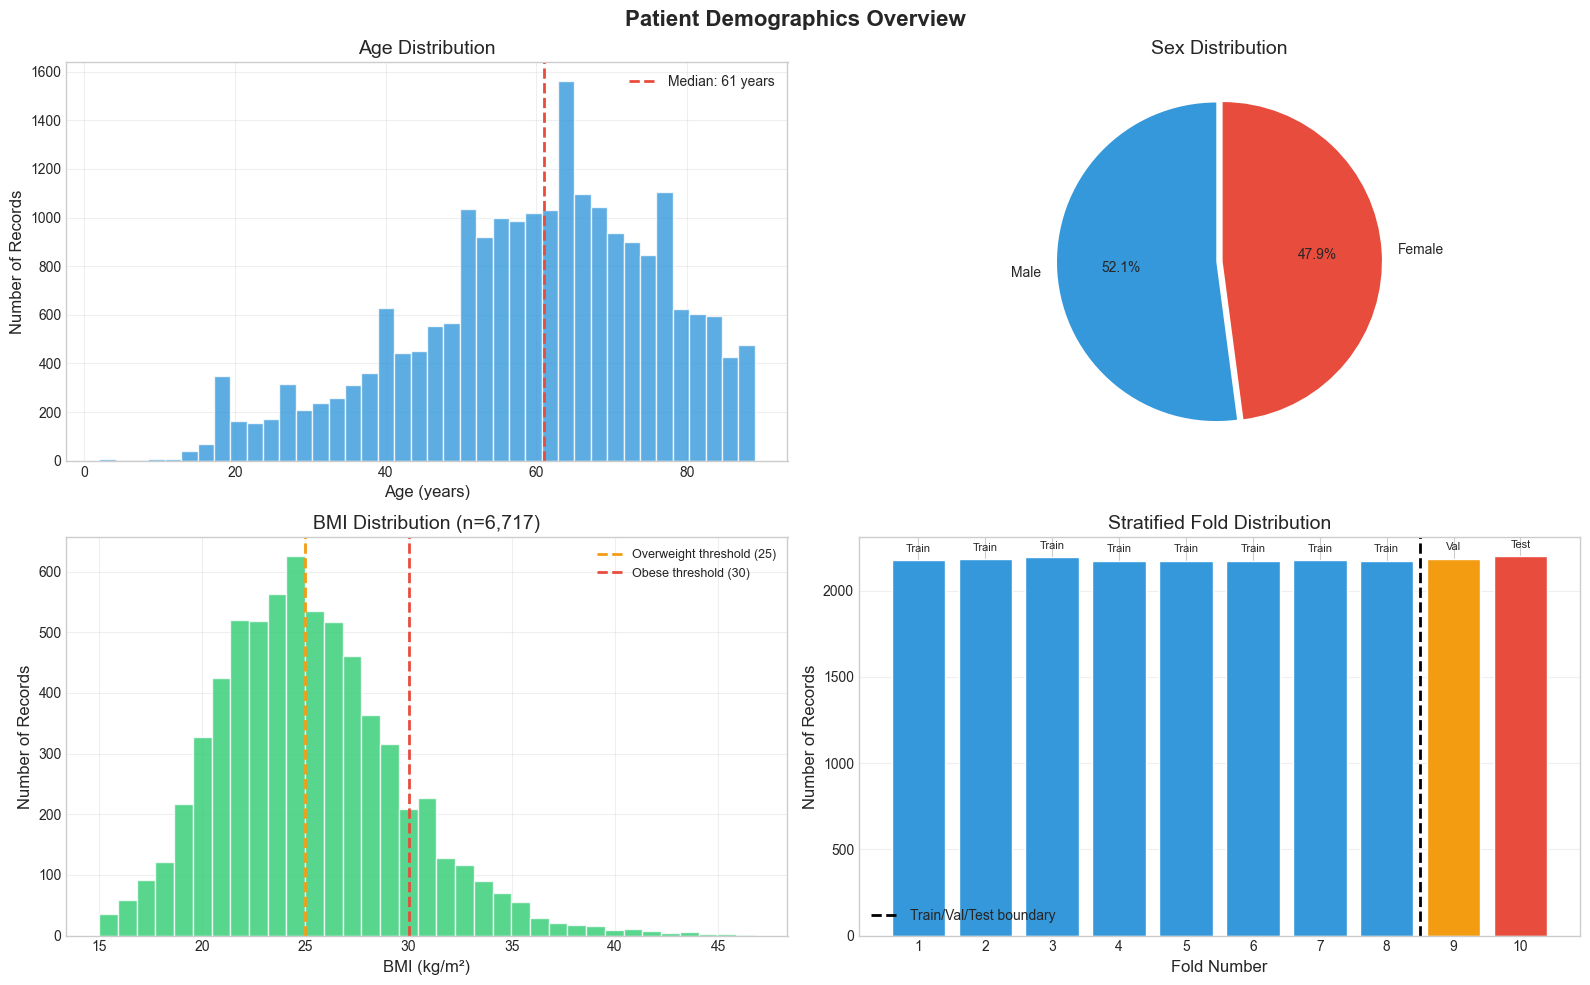

✓ Demographics visualization saved to outputs/demographics.png


In [14]:
# ============================================================================
# DEMOGRAPHICS VISUALIZATION
# ============================================================================

# Create a 2x2 subplot for demographics
fig, axes = plt.subplots(2, 2, figsize=FIG_SIZES['large'])
fig.suptitle('Patient Demographics Overview', fontsize=16, fontweight='bold')

# 1. Age Distribution (filtering out HIPAA-masked values > 100)
ax1 = axes[0, 0]
age_valid = df[df['age'] <= 100]['age']
ax1.hist(age_valid, bins=40, color='#3498db', edgecolor='white', alpha=0.8)
ax1.axvline(age_valid.median(), color='#e74c3c', linestyle='--', linewidth=2, 
            label=f'Median: {age_valid.median():.0f} years')
ax1.set_xlabel('Age (years)', fontsize=12)
ax1.set_ylabel('Number of Records', fontsize=12)
ax1.set_title('Age Distribution', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Sex Distribution (Pie Chart)
ax2 = axes[0, 1]
sex_counts = df['sex'].value_counts()
sex_labels = ['Male', 'Female']
sex_colors = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax2.pie(
    sex_counts.values, 
    labels=sex_labels,
    colors=sex_colors,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.02, 0.02)
)
ax2.set_title('Sex Distribution', fontsize=14)

# 3. BMI Distribution (calculate from height/weight)
ax3 = axes[1, 0]
# Calculate BMI where both height and weight are available
mask = df['height'].notna() & df['weight'].notna()
bmi = df.loc[mask, 'weight'] / ((df.loc[mask, 'height'] / 100) ** 2)
# Filter to reasonable BMI range (15-50)
bmi_valid = bmi[(bmi >= 15) & (bmi <= 50)]
ax3.hist(bmi_valid, bins=35, color='#2ecc71', edgecolor='white', alpha=0.8)
ax3.axvline(25, color='#f39c12', linestyle='--', linewidth=2, label='Overweight threshold (25)')
ax3.axvline(30, color='#e74c3c', linestyle='--', linewidth=2, label='Obese threshold (30)')
ax3.set_xlabel('BMI (kg/m²)', fontsize=12)
ax3.set_ylabel('Number of Records', fontsize=12)
ax3.set_title(f'BMI Distribution (n={len(bmi_valid):,})', fontsize=14)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Stratified Fold Distribution
ax4 = axes[1, 1]
fold_counts = df['strat_fold'].value_counts().sort_index()
colors = ['#3498db'] * 8 + ['#f39c12', '#e74c3c']  # Blue for train, orange for val, red for test
bars = ax4.bar(fold_counts.index, fold_counts.values, color=colors, edgecolor='white')
ax4.axvline(8.5, color='black', linestyle='--', linewidth=2, label='Train/Val/Test boundary')
ax4.set_xlabel('Fold Number', fontsize=12)
ax4.set_ylabel('Number of Records', fontsize=12)
ax4.set_title('Stratified Fold Distribution', fontsize=14)
ax4.set_xticks(range(1, 11))
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add labels for split assignment
for i, (fold, count) in enumerate(fold_counts.items()):
    label = 'Train' if fold <= 8 else ('Val' if fold == 9 else 'Test')
    ax4.annotate(label, (fold, count + 50), ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'demographics.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Demographics visualization saved to outputs/demographics.png")

In [15]:
# ============================================================================
# DIAGNOSIS SUPERCLASS ANALYSIS
# ============================================================================

def get_diagnostic_superclass(scp_codes, scp_df):
    superclasses = []
    for code in scp_codes.keys():
        if code in scp_df.index:
            sc = scp_df.loc[code, 'diagnostic_class']
            if pd.notna(sc):
                superclasses.append(sc)
    return list(set(superclasses))

# Apply to create diagnostic_superclass column
print("Extracting diagnostic superclasses...")
df['diagnostic_superclass'] = df['scp_codes'].apply(
    lambda x: get_diagnostic_superclass(x, scp_df)
)

# Count occurrences of each superclass
# Note: Sum exceeds total records because ECGs can have multiple labels
superclass_counts = Counter()
for classes in df['diagnostic_superclass']:
    for sc in classes:
        superclass_counts[sc] += 1

print("\n📊 Diagnostic Superclass Distribution:")
print("-" * 50)
superclass_order = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
for sc in superclass_order:
    count = superclass_counts.get(sc, 0)
    pct = 100 * count / len(df)
    print(f"   {sc:5}: {count:,} records ({pct:.1f}%)")

print(f"\n   Note: Total exceeds 100% because ECGs can have multiple diagnoses")
print(f"   Average labels per ECG: {sum(superclass_counts.values()) / len(df):.2f}")

Extracting diagnostic superclasses...

📊 Diagnostic Superclass Distribution:
--------------------------------------------------
   NORM : 9,514 records (43.6%)
   MI   : 5,469 records (25.1%)
   STTC : 5,235 records (24.0%)
   CD   : 4,898 records (22.5%)
   HYP  : 2,649 records (12.2%)

   Note: Total exceeds 100% because ECGs can have multiple diagnoses
   Average labels per ECG: 1.27


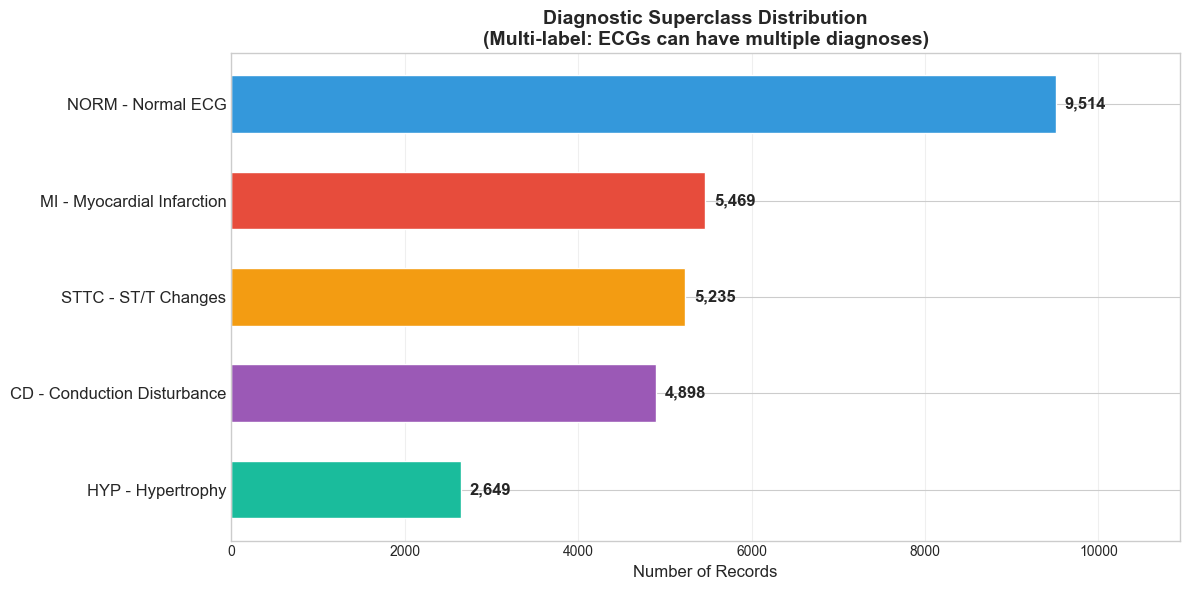

✓ Diagnosis distribution saved to outputs/diagnosis_distribution.png


In [16]:
# ============================================================================
# DIAGNOSIS DISTRIBUTION VISUALIZATION
# ============================================================================

# Superclass descriptions for the legend
superclass_descriptions = {
    'NORM': 'Normal ECG',
    'MI': 'Myocardial Infarction',
    'STTC': 'ST/T Changes',
    'CD': 'Conduction Disturbance',
    'HYP': 'Hypertrophy'
}

fig, ax = plt.subplots(figsize=(12, 6))

# Create horizontal bar chart
y_pos = np.arange(len(superclass_order))
counts = [superclass_counts[sc] for sc in superclass_order]
colors = [SUPERCLASS_COLORS[sc] for sc in superclass_order]

bars = ax.barh(y_pos, counts, color=colors, edgecolor='white', height=0.6)

# Add count labels on bars
for i, (bar, count) in enumerate(zip(bars, counts)):
    ax.text(count + 100, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=12, fontweight='bold')

# Customize axes
ax.set_yticks(y_pos)
ax.set_yticklabels([f"{sc} - {superclass_descriptions[sc]}" for sc in superclass_order], fontsize=12)
ax.set_xlabel('Number of Records', fontsize=12)
ax.set_title('Diagnostic Superclass Distribution\n(Multi-label: ECGs can have multiple diagnoses)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, max(counts) * 1.15)
ax.grid(True, alpha=0.3, axis='x')

# Invert y-axis to show NORM at top
ax.invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'diagnosis_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Diagnosis distribution saved to outputs/diagnosis_distribution.png")

In [17]:
# ============================================================================
# 12-LEAD ECG VISUALIZATION FUNCTION
# ============================================================================

def plot_12lead_ecg(ecg_signal, title="12-Lead ECG", save_path=None):
    fig, axes = plt.subplots(6, 2, figsize=FIG_SIZES['ecg_12lead'])
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    # Time axis in seconds
    time = np.arange(ecg_signal.shape[0]) / CONFIG['sampling_rate']
    
    # Plot each lead
    for i, (ax, lead_name) in enumerate(zip(axes.flat, LEAD_NAMES)):
        ax.plot(time, ecg_signal[:, i], color='#2c3e50', linewidth=0.5)
        ax.set_ylabel(lead_name, fontsize=10, fontweight='bold', rotation=0, labelpad=20)
        ax.set_xlim(0, CONFIG['duration'])
        ax.grid(True, which='both', alpha=0.3)
        ax.set_axisbelow(True)
        
        # Only show x-label on bottom row
        if i >= 10:
            ax.set_xlabel('Time (seconds)', fontsize=10)
        else:
            ax.set_xticklabels([])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved to {save_path}")
    
    plt.show()
    return fig

print("✓ ECG visualization function defined")

✓ ECG visualization function defined


✓ Saved to outputs/ecg_sample_NORM.png


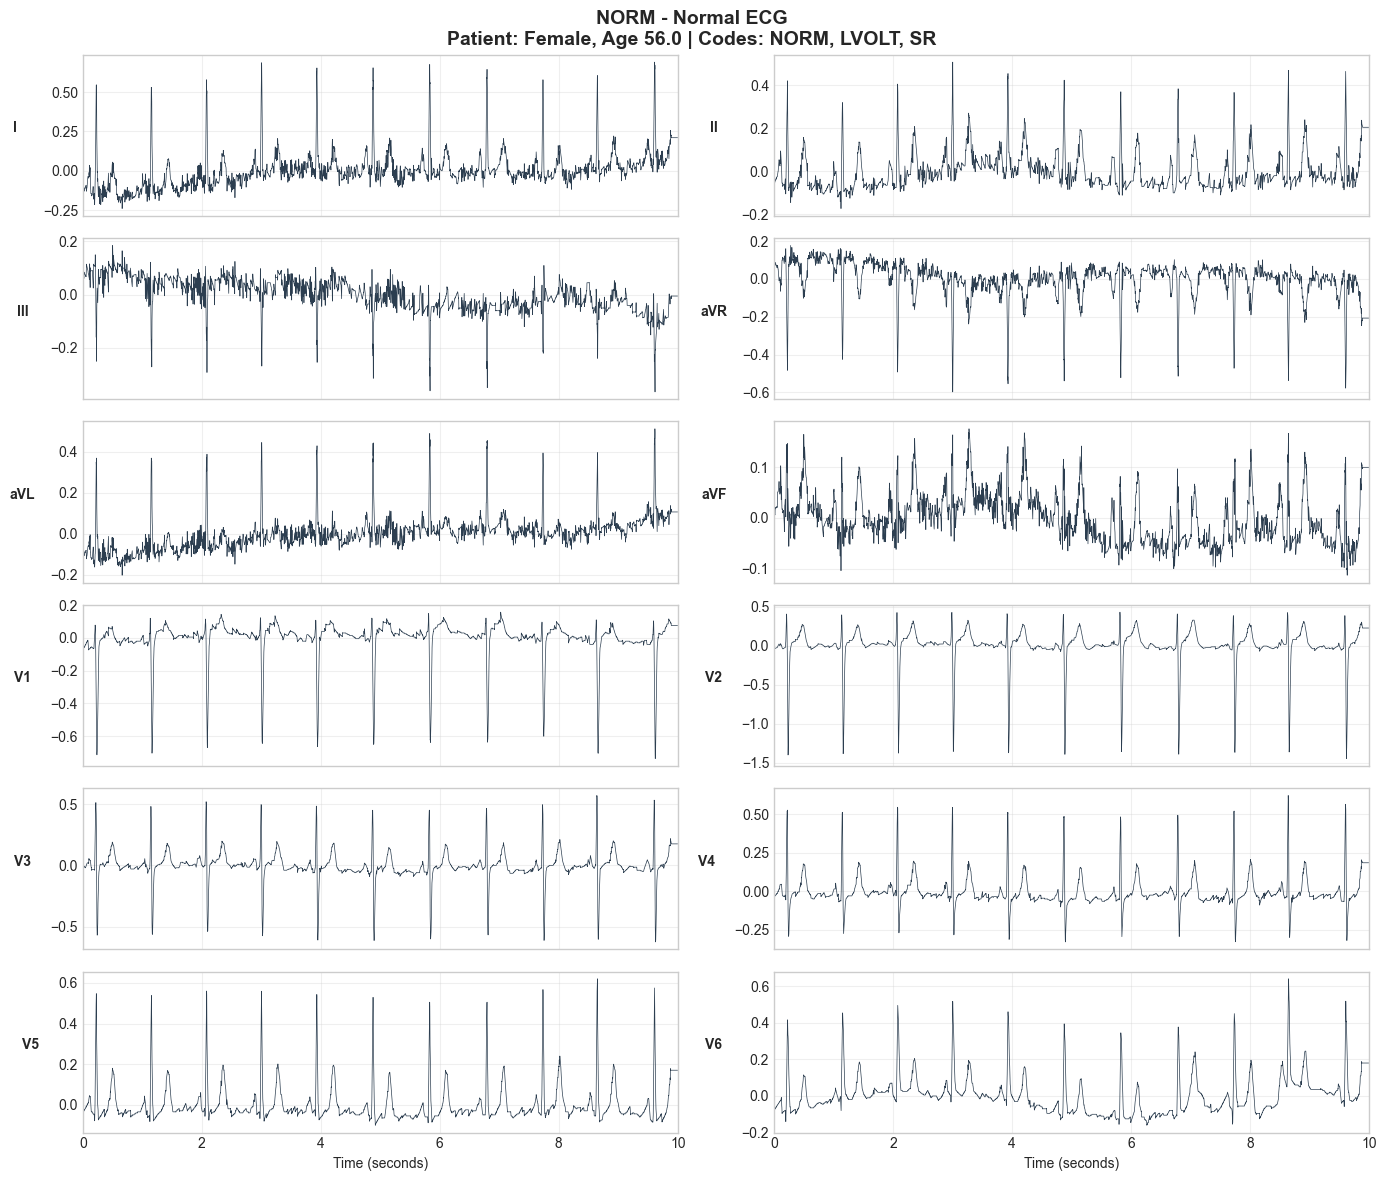


NORM: ECG ID 1
   Diagnoses: ['NORM', 'LVOLT', 'SR']
✓ Saved to outputs/ecg_sample_MI.png


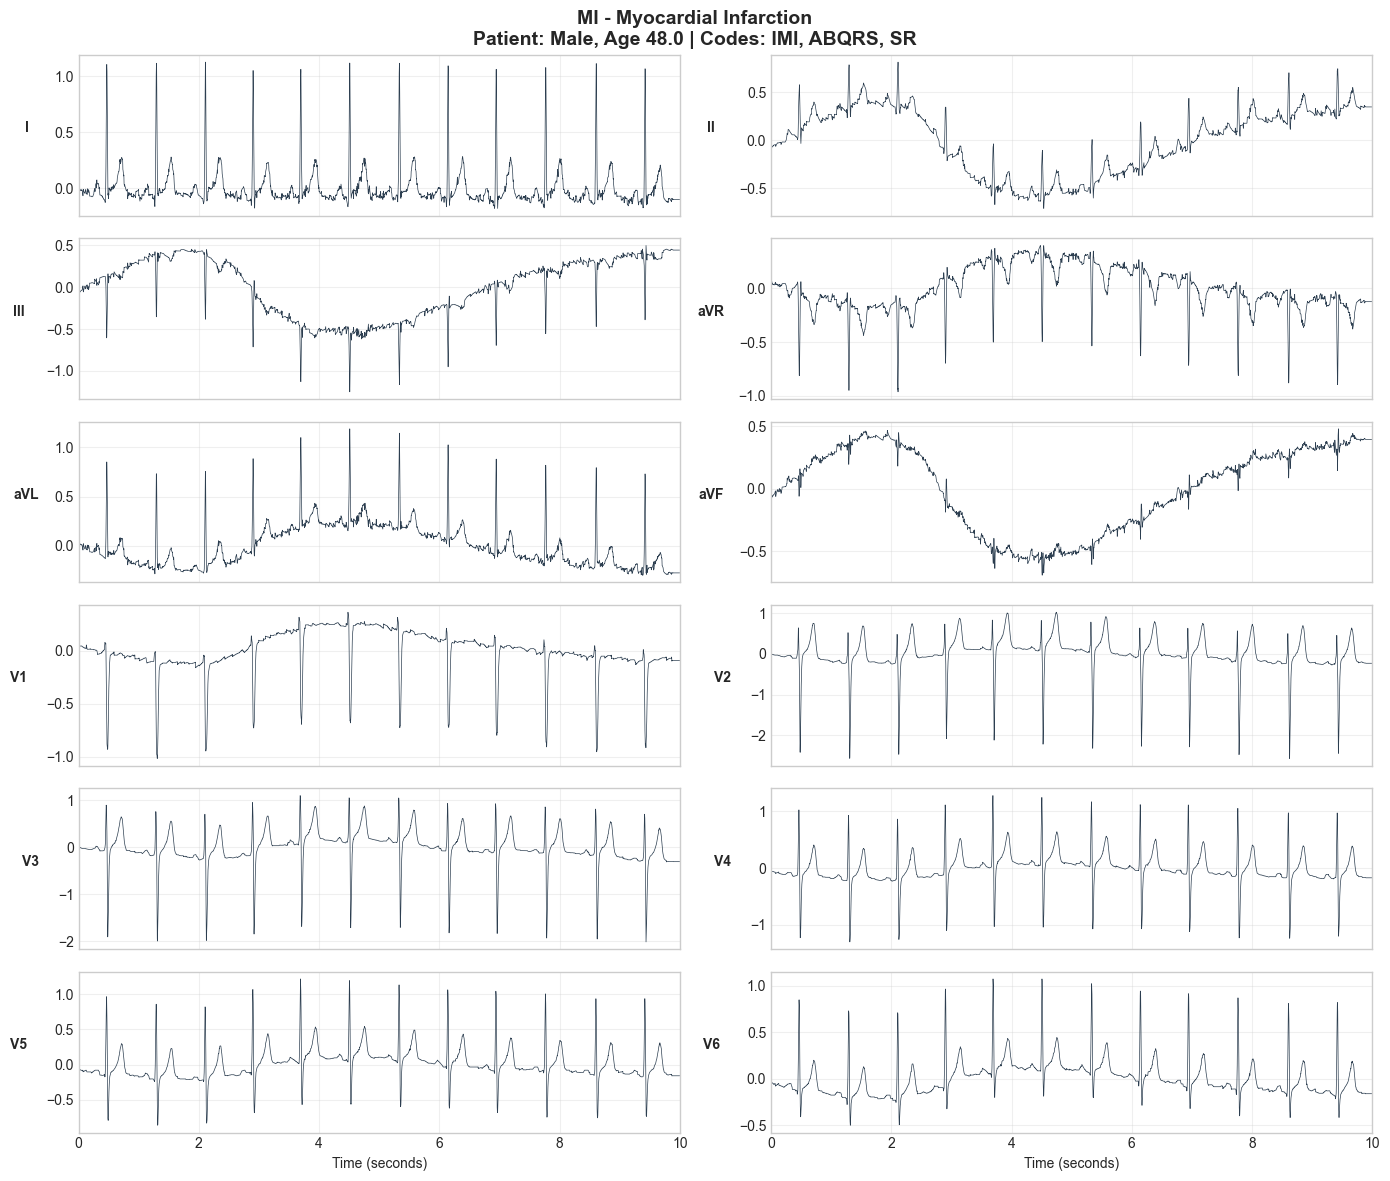


MI: ECG ID 8
   Diagnoses: ['IMI', 'ABQRS', 'SR']
✓ Saved to outputs/ecg_sample_STTC.png


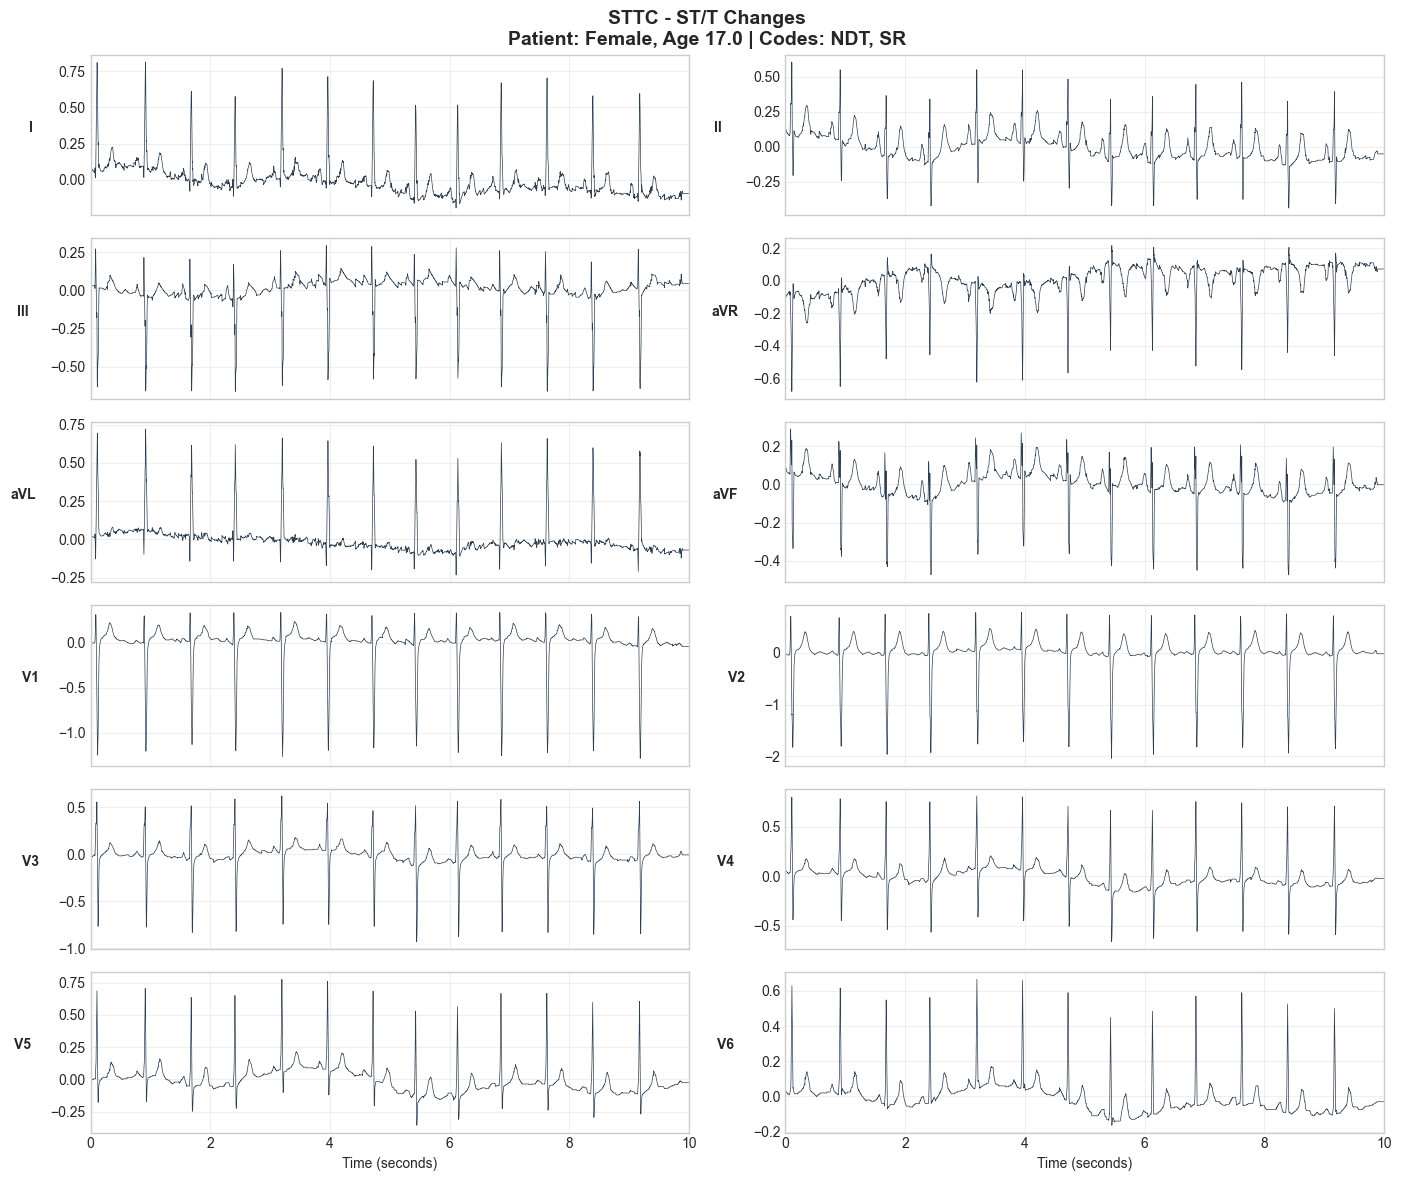


STTC: ECG ID 22
   Diagnoses: ['NDT', 'SR']
✓ Saved to outputs/ecg_sample_CD.png


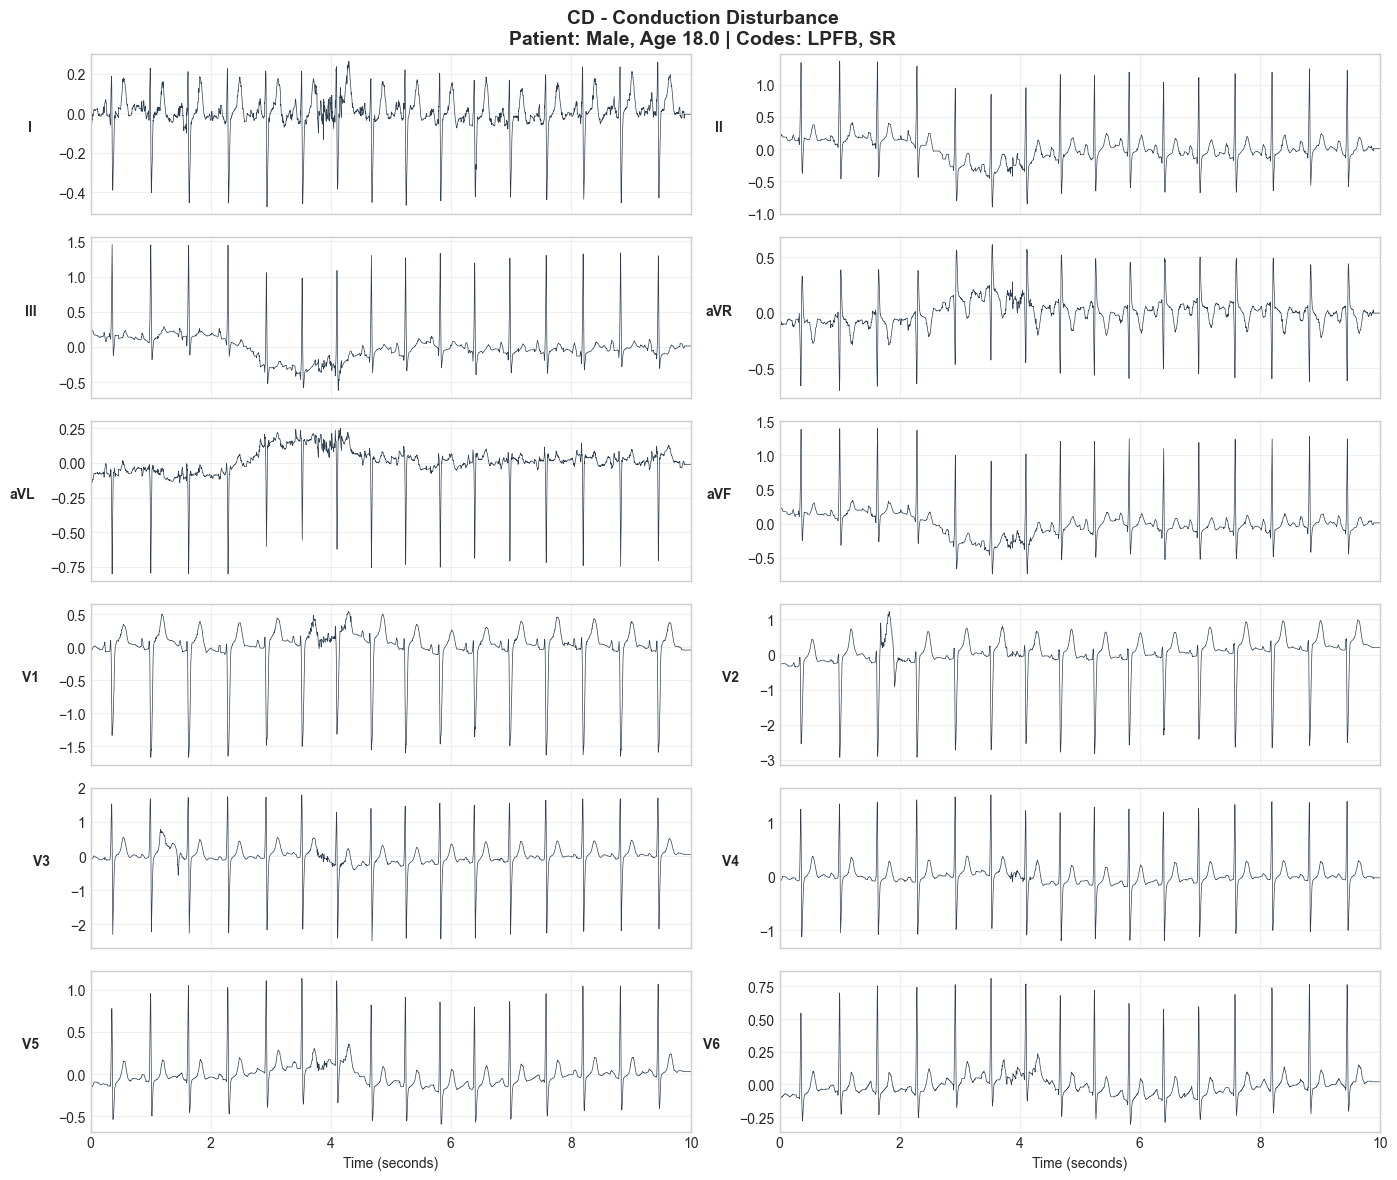


CD: ECG ID 32
   Diagnoses: ['LPFB', 'SR']
✓ Saved to outputs/ecg_sample_HYP.png


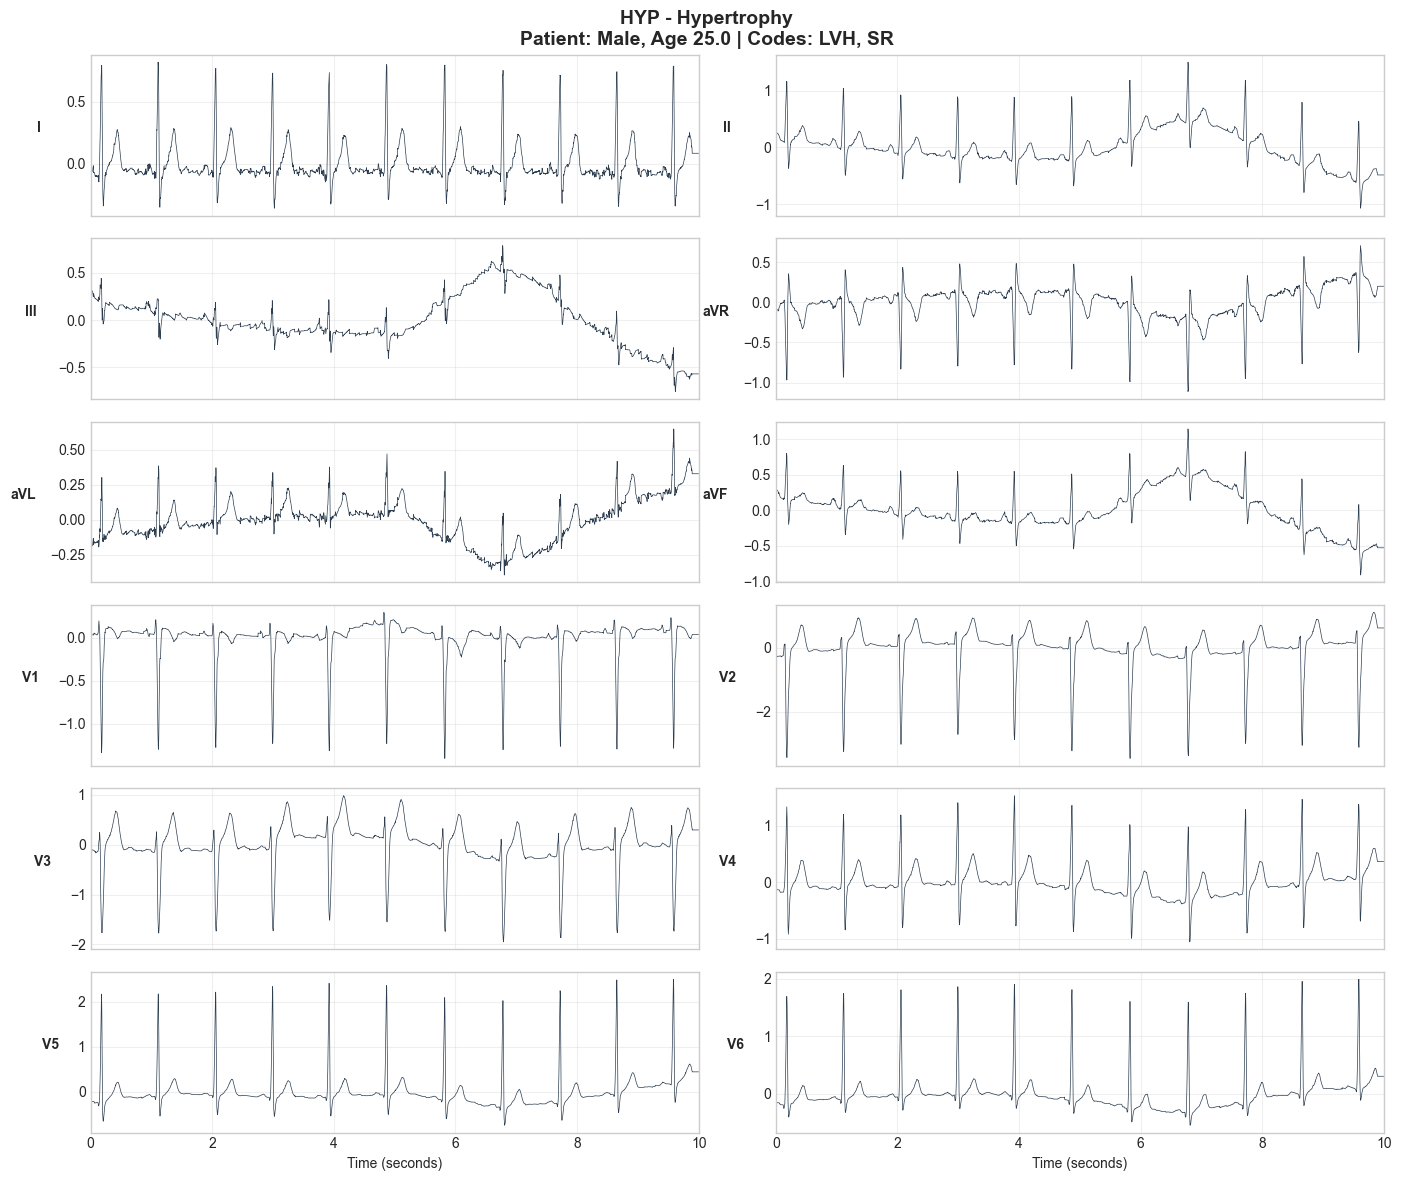


HYP: ECG ID 30
   Diagnoses: ['LVH', 'SR']

✓ Sample ECGs saved for all 5 diagnostic superclasses


In [18]:
# ============================================================================
# SAMPLE ECG FROM EACH DIAGNOSTIC SUPERCLASS
# ============================================================================

for superclass in superclass_order:
    # Find first record containing this superclass
    for idx, row in df.iterrows():
        if superclass in row['diagnostic_superclass']:
            # Load ECG
            ecg = load_ecg_waveform(row['filename_hr'], CONFIG['data_path'])
            
            # Create title with patient info
            age = row['age'] if row['age'] <= 100 else '>89'
            sex = 'Female' if row['sex'] == 1 else 'Male'
            codes = list(row['scp_codes'].keys())[:5]  # Show up to 5 codes
            
            title = f"{superclass} - {superclass_descriptions[superclass]}\n"
            title += f"Patient: {sex}, Age {age} | Codes: {', '.join(codes)}"
            
            # Plot and save
            save_path = os.path.join(CONFIG['output_path'], f'ecg_sample_{superclass}.png')
            plot_12lead_ecg(ecg, title=title, save_path=save_path)
            
            print(f"\n{superclass}: ECG ID {idx}")
            print(f"   Diagnoses: {codes}")
            break

print("\n✓ Sample ECGs saved for all 5 diagnostic superclasses")

In [19]:
# ============================================================================
# SIGNAL QUALITY ANALYSIS
# ============================================================================

# Quality-related columns
quality_cols = ['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems']

print("\n📊 Signal Quality Issues:")
print("-" * 50)

# Count records with quality issues (non-null means issue present)
for col in quality_cols:
    issue_count = df[col].notna().sum()
    pct = 100 * issue_count / len(df)
    print(f"   {col:20}: {issue_count:,} records ({pct:.1f}%)")

# Extra beats and pacemaker
print("\n📊 Special Conditions:")
print("-" * 50)

# Extra beats (count non-null and non-empty)
extra_beats_count = df['extra_beats'].notna().sum()
print(f"   Extra beats noted:   {extra_beats_count:,} ({100*extra_beats_count/len(df):.1f}%)")

# Pacemaker
pacemaker_count = df['pacemaker'].notna().sum()
print(f"   Pacemaker detected:  {pacemaker_count:,} ({100*pacemaker_count/len(df):.1f}%)")

print("\n✓ Signal Quality Summary:")
print("   PTB-XL signals are hospital-grade and relatively clean.")
print("   Most quality issues affect only specific leads, not entire recordings.")
print("   Light preprocessing is sufficient for most analyses.")


📊 Signal Quality Issues:
--------------------------------------------------
   baseline_drift      : 1,598 records (7.3%)
   static_noise        : 3,260 records (15.0%)
   burst_noise         : 613 records (2.8%)
   electrodes_problems : 30 records (0.1%)

📊 Special Conditions:
--------------------------------------------------
   Extra beats noted:   1,949 (8.9%)
   Pacemaker detected:  291 (1.3%)

✓ Signal Quality Summary:
   PTB-XL signals are hospital-grade and relatively clean.
   Most quality issues affect only specific leads, not entire recordings.
   Light preprocessing is sufficient for most analyses.


---

## Section 3 Summary

### What we accomplished:
1. **Demographics visualization** - Age, sex, BMI distributions and fold assignments
2. **Diagnosis analysis** - Counted occurrences of each diagnostic superclass
3. **ECG visualization** - Created 12-lead plots for samples from each category
4. **Signal quality review** - Assessed noise and artifact levels

### Key insights:
- **Class imbalance**: NORM (43.6%) is most common, HYP (12.2%) least common
- **Multi-label nature**: Average of ~1.3 labels per ECG
- **Demographics**: Median age 62, fairly balanced sex distribution
- **Signal quality**: Hospital-grade recordings, minimal preprocessing needed

### Visualizations saved:
- `outputs/demographics.png` - Patient demographics overview
- `outputs/diagnosis_distribution.png` - Diagnostic superclass distribution
- `outputs/ecg_sample_NORM.png` through `ecg_sample_HYP.png` - Sample ECGs

### Key function created:
- `get_diagnostic_superclass()` - Extracts superclass labels from SCP codes
- `plot_12lead_ecg()` - Creates clinical-format 12-lead ECG plots

### Next: Section 4 - Label Engineering
We'll create risk scores from the diagnoses for our prediction targets.

---

# Section 4: Label Engineering

## What we're doing here:
This section creates prediction targets (labels) from the diagnostic codes:

1. **ECG Risk Score (0-3)** - Based on severity of ECG findings
2. **Age Risk Factor** - Cardiovascular risk increases with age
3. **Composite Risk Score** - Combined ECG + demographic factors
4. **Binary Target** - Simplified high-risk vs. low-risk classification

### Why this matters:
- Raw diagnosis codes are complex (71 different codes, multi-label)
- Clinical risk stratification requires synthesizing multiple factors
- Our models need well-defined targets to predict
- Different scoring approaches enable different model comparisons

### Clinical rationale:
Risk scores are based on established cardiology guidelines:
- **High risk**: Myocardial infarction, dangerous arrhythmias, severe conduction blocks
- **Moderate risk**: Hypertrophy, bundle branch blocks, ischemic changes
- **Low risk**: Minor rate variations, benign findings

In [20]:
# ============================================================================
# ECG-BASED RISK SCORE
# ============================================================================

def calculate_ecg_risk_score(scp_codes):
    codes = set(scp_codes.keys())
    
    # Check for high-risk conditions
    if any(code in codes for code in HIGH_RISK_CODES):
        return 3
    
    # Check for moderate-risk conditions
    if any(code in codes for code in MODERATE_RISK_CODES):
        return 2
    
    # Check for low-risk conditions
    if any(code in codes for code in LOW_RISK_CODES):
        return 1
    
    # Normal or no significant findings
    return 0

# Apply to create ecg_risk_score column
print("Calculating ECG risk scores...")
df['ecg_risk_score'] = df['scp_codes'].apply(calculate_ecg_risk_score)

# Display distribution
print("\n📊 ECG Risk Score Distribution:")
print("-" * 50)
risk_counts = df['ecg_risk_score'].value_counts().sort_index()
risk_labels = {0: 'Normal (0)', 1: 'Low Risk (1)', 2: 'Moderate Risk (2)', 3: 'High Risk (3)'}
for score, count in risk_counts.items():
    pct = 100 * count / len(df)
    print(f"   {risk_labels[score]:20}: {count:,} ({pct:.1f}%)")

Calculating ECG risk scores...

📊 ECG Risk Score Distribution:
--------------------------------------------------
   Normal (0)          : 547 (2.5%)
   Low Risk (1)        : 10,764 (49.4%)
   Moderate Risk (2)   : 3,784 (17.4%)
   High Risk (3)       : 6,704 (30.8%)


In [21]:
# ============================================================================
# AGE-BASED RISK FACTOR
# ============================================================================

def calculate_age_risk(age):
    if pd.isna(age) or age > 100:  # Handle HIPAA-masked values
        return 1  # Default to moderate
    
    if age >= 75:
        return 3
    elif age >= 65:
        return 2
    elif age >= 55:
        return 1
    else:
        return 0

# Apply to create age_risk column
df['age_risk'] = df['age'].apply(calculate_age_risk)

print("📊 Age Risk Distribution:")
print("-" * 50)
age_risk_counts = df['age_risk'].value_counts().sort_index()
age_labels = {0: '<55 years (0)', 1: '55-64 years (1)', 2: '65-74 years (2)', 3: '75+ years (3)'}
for score, count in age_risk_counts.items():
    pct = 100 * count / len(df)
    print(f"   {age_labels[score]:20}: {count:,} ({pct:.1f}%)")

📊 Age Risk Distribution:
--------------------------------------------------
   <55 years (0)       : 7,264 (33.3%)
   55-64 years (1)     : 5,339 (24.5%)
   65-74 years (2)     : 4,898 (22.5%)
   75+ years (3)       : 4,298 (19.7%)


In [23]:
# ============================================================================
# COMPOSITE RISK SCORE
# ============================================================================

def calculate_composite_risk(row):
    # Weight factors
    ecg_weight = 2.0
    age_weight = 1.0
    sex_adjustment = 0.5 if row['sex'] == 0 else 0  # 0 = Male
    
    # Calculate weighted sum
    raw_score = (
        row['ecg_risk_score'] * ecg_weight +
        row['age_risk'] * age_weight +
        sex_adjustment
    )
    
    # Maximum possible score: 3*2 + 3*1 + 0.5 = 9.5
    max_score = 9.5
    
    # Normalize to 0-1 range
    normalized = raw_score / max_score
    
    return min(normalized, 1.0)  # Cap at 1.0

# Apply to create composite_risk column
df['composite_risk'] = df.apply(calculate_composite_risk, axis=1)

In [24]:
# ============================================================================
# RISK CATEGORIES AND BINARY TARGET
# ============================================================================

# Create risk category bins
def get_risk_category(composite_risk):
    """
    Bin composite risk into clinical categories.
    
    Categories:
    - Low: 0.0 - 0.3 (minimal intervention needed)
    - Moderate: 0.3 - 0.6 (lifestyle modification, monitoring)
    - High: 0.6 - 1.0 (active intervention, close follow-up)
    """
    if composite_risk < 0.3:
        return 'Low'
    elif composite_risk < 0.6:
        return 'Moderate'
    else:
        return 'High'

df['risk_category'] = df['composite_risk'].apply(get_risk_category)

# Create binary classification target
# High risk if composite >= 0.5 OR ECG score >= 2 (any significant finding)
df['high_risk_binary'] = ((df['composite_risk'] >= 0.5) | (df['ecg_risk_score'] >= 2)).astype(int)

print("📊 Risk Category Distribution:")
print("-" * 50)
cat_counts = df['risk_category'].value_counts()
for cat in ['Low', 'Moderate', 'High']:
    count = cat_counts.get(cat, 0)
    pct = 100 * count / len(df)
    color = RISK_COLORS.get(cat, '#333')
    print(f"   {cat:10}: {count:,} ({pct:.1f}%)")

print("\n📊 Binary Target Distribution:")
print("-" * 50)
binary_counts = df['high_risk_binary'].value_counts().sort_index()
print(f"   Low/Normal (0): {binary_counts.get(0, 0):,} ({100*binary_counts.get(0,0)/len(df):.1f}%)")
print(f"   High Risk (1):  {binary_counts.get(1, 0):,} ({100*binary_counts.get(1,0)/len(df):.1f}%)")

📊 Risk Category Distribution:
--------------------------------------------------
   Low       : 5,701 (26.2%)
   Moderate  : 7,276 (33.4%)
   High      : 8,822 (40.5%)

📊 Binary Target Distribution:
--------------------------------------------------
   Low/Normal (0): 10,145 (46.5%)
   High Risk (1):  11,654 (53.5%)


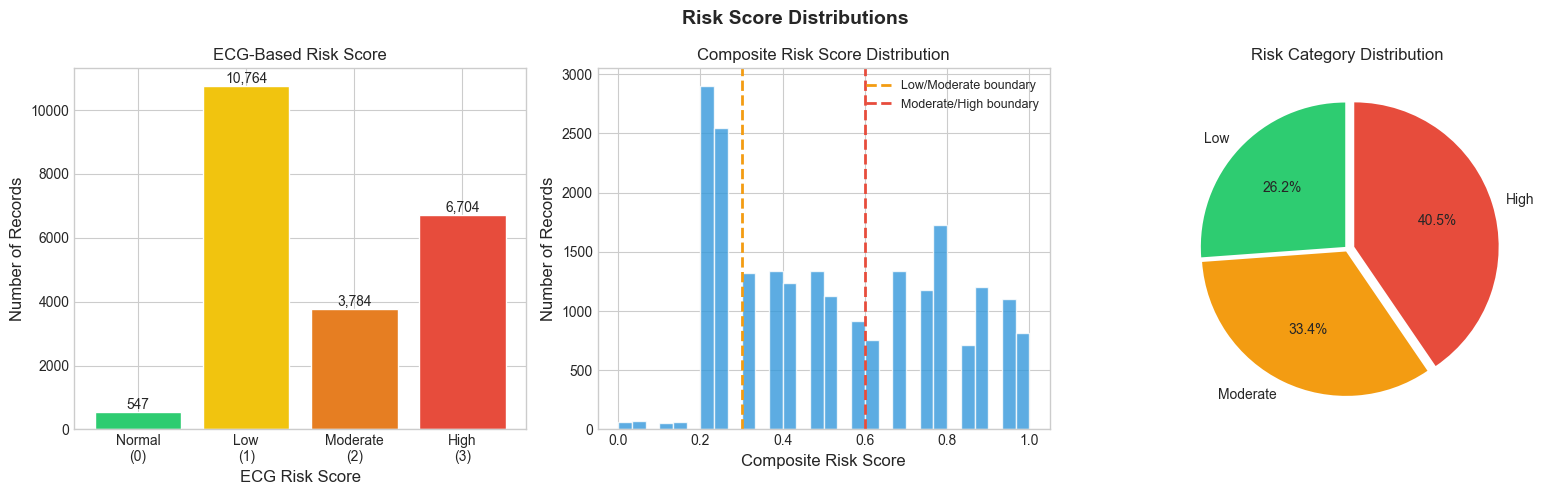

✓ Risk distribution visualization saved


In [25]:
# ============================================================================
# RISK SCORE VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Risk Score Distributions', fontsize=14, fontweight='bold')

# 1. ECG Risk Score Distribution
ax1 = axes[0]
risk_counts = df['ecg_risk_score'].value_counts().sort_index()
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
bars = ax1.bar(risk_counts.index, risk_counts.values, color=colors, edgecolor='white')
ax1.set_xlabel('ECG Risk Score', fontsize=12)
ax1.set_ylabel('Number of Records', fontsize=12)
ax1.set_title('ECG-Based Risk Score', fontsize=12)
ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels(['Normal\n(0)', 'Low\n(1)', 'Moderate\n(2)', 'High\n(3)'])
for bar, count in zip(bars, risk_counts.values):
    ax1.annotate(f'{count:,}', (bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10)

# 2. Composite Risk Score Distribution (Histogram)
ax2 = axes[1]
ax2.hist(df['composite_risk'], bins=30, color='#3498db', edgecolor='white', alpha=0.8)
# Add category boundaries
ax2.axvline(0.3, color='#f39c12', linestyle='--', linewidth=2, label='Low/Moderate boundary')
ax2.axvline(0.6, color='#e74c3c', linestyle='--', linewidth=2, label='Moderate/High boundary')
ax2.set_xlabel('Composite Risk Score', fontsize=12)
ax2.set_ylabel('Number of Records', fontsize=12)
ax2.set_title('Composite Risk Score Distribution', fontsize=12)
ax2.legend(fontsize=9)

# 3. Risk Category Pie Chart
ax3 = axes[2]
cat_counts = df['risk_category'].value_counts()
cat_order = ['Low', 'Moderate', 'High']
sizes = [cat_counts.get(cat, 0) for cat in cat_order]
colors_pie = [RISK_COLORS[cat] for cat in cat_order]
wedges, texts, autotexts = ax3.pie(
    sizes, labels=cat_order, colors=colors_pie,
    autopct='%1.1f%%', startangle=90, explode=(0.02, 0.02, 0.05)
)
ax3.set_title('Risk Category Distribution', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['output_path'], 'risk_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Risk distribution visualization saved")

---

## Section 4 Summary

### What we accomplished:
1. **ECG Risk Score (0-3)** - Based on severity of ECG diagnostic codes
2. **Age Risk Factor (0-3)** - Based on age brackets (<55, 55-64, 65-74, 75+)
3. **Composite Risk Score (0-1)** - Weighted combination of ECG + age + sex factors
4. **Risk Categories** - Low/Moderate/High bins for clinical interpretation
5. **Binary Target** - Simplified high-risk classification for baseline models

### New columns created:
| Column | Description | Range |
|--------|-------------|-------|
| `ecg_risk_score` | ECG-based severity | 0-3 |
| `age_risk` | Age-based risk factor | 0-3 |
| `composite_risk` | Normalized combined risk | 0.0-1.0 |
| `risk_category` | Clinical category | Low/Moderate/High |
| `high_risk_binary` | Binary classification target | 0/1 |

### Key functions created:
- `calculate_ecg_risk_score()` - Maps diagnosis codes to risk level
- `calculate_age_risk()` - Maps age to risk factor
- `calculate_composite_risk()` - Combines all factors
- `get_risk_category()` - Bins into clinical categories

### Model targets:
- **Multi-class**: `ecg_risk_score` (4 classes: 0, 1, 2, 3)
- **Binary**: `high_risk_binary` (2 classes: 0, 1)

### Next: Section 5 - ECG Signal Processing
We'll normalize signals and detect R-peaks for feature extraction.

---

# Section 5: ECG Signal Processing

## What we're doing here:
This section prepares ECG signals for analysis:

1. **Normalization** - Z-score normalization for consistent amplitude scaling
2. **Optional filtering** - Light bandpass filter for noisy signals
3. **R-peak detection** - Finding heartbeat locations for HRV analysis
4. **Heart rate calculation** - Computing BPM from R-R intervals

### Why this matters:
- Raw ECG amplitudes vary between patients and devices
- Normalization ensures fair comparison across recordings
- R-peak detection enables heart rate variability (HRV) features
- HRV is a powerful predictor of cardiac health

### Note on PTB-XL signal quality:
The signals are already relatively clean (hospital-grade equipment). Heavy preprocessing is not necessary - we focus on:
- Normalization for consistent scaling
- R-peak detection for HRV analysis

In [26]:
# ============================================================================
# ECG NORMALIZATION
# ============================================================================

def normalize_ecg(ecg_signal, epsilon=1e-8):
    normalized = np.zeros_like(ecg_signal, dtype=np.float32)
    
    for lead in range(ecg_signal.shape[1]):
        lead_signal = ecg_signal[:, lead]
        mean = np.mean(lead_signal)
        std = np.std(lead_signal)
        normalized[:, lead] = (lead_signal - mean) / (std + epsilon)
    
    return normalized

# Test normalization
print("Testing ECG normalization...")
sample_ecg = load_ecg_waveform(df.iloc[0]['filename_hr'], CONFIG['data_path'])
normalized_ecg = normalize_ecg(sample_ecg)

print("\n📊 Before Normalization:")
print(f"   Mean per lead: {sample_ecg.mean(axis=0).round(2)}")
print(f"   Std per lead:  {sample_ecg.std(axis=0).round(2)}")

print("\n📊 After Normalization:")
print(f"   Mean per lead: {normalized_ecg.mean(axis=0).round(4)}")
print(f"   Std per lead:  {normalized_ecg.std(axis=0).round(4)}")

print("\n✓ Normalization successful - zero mean, unit variance per lead")

Testing ECG normalization...

📊 Before Normalization:
   Mean per lead: [ 0.    0.   -0.   -0.    0.    0.   -0.    0.01 -0.   -0.    0.    0.  ]
   Std per lead:  [0.11 0.09 0.06 0.09 0.08 0.05 0.11 0.22 0.12 0.1  0.09 0.1 ]

📊 After Normalization:
   Mean per lead: [ 0. -0.  0.  0.  0.  0. -0.  0.  0. -0.  0. -0.]
   Std per lead:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

✓ Normalization successful - zero mean, unit variance per lead


In [27]:
# ============================================================================
# OPTIONAL BANDPASS FILTER
# ============================================================================

def light_filter_ecg(ecg_signal, lowcut=0.5, highcut=40, fs=500, order=2):
    # Design Butterworth bandpass filter
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    
    # Apply filter to each lead
    filtered = np.zeros_like(ecg_signal, dtype=np.float32)
    for lead in range(ecg_signal.shape[1]):
        filtered[:, lead] = signal.filtfilt(b, a, ecg_signal[:, lead])
    
    return filtered

print("✓ Bandpass filter function defined (0.5-40 Hz)")
print("   Note: PTB-XL signals are generally clean - filtering is optional")

✓ Bandpass filter function defined (0.5-40 Hz)
   Note: PTB-XL signals are generally clean - filtering is optional


In [ ]:
# ============================================================================
# R-PEAK DETECTION
# ============================================================================

def detect_r_peaks(ecg_lead, fs=500, min_distance_sec=0.3):

    # Minimum distance in samples
    min_distance = int(min_distance_sec * fs)
    
    # Adaptive height threshold: must be above mean + 0.5*std
    # This helps handle varying signal amplitudes
    height_threshold = np.mean(ecg_lead) + 0.5 * np.std(ecg_lead)
    
    # Find peaks
    peaks, properties = signal.find_peaks(
        ecg_lead,
        distance=min_distance,
        height=height_threshold,
        prominence=0.1 * np.std(ecg_lead)  # Must have some prominence
    )
    
    return peaks


def calculate_heart_rate(r_peaks, fs=500):
    if len(r_peaks) < 2:
        return {'mean_hr': np.nan, 'min_hr': np.nan, 'max_hr': np.nan}
    
    # Calculate RR intervals in milliseconds
    rr_intervals = np.diff(r_peaks) / fs * 1000  # Convert to ms
    
    # Filter implausible intervals (30-200 BPM range)
    valid_mask = (rr_intervals >= CONFIG['min_rr_interval']) & \
                 (rr_intervals <= CONFIG['max_rr_interval'])
    valid_rr = rr_intervals[valid_mask]
    
    if len(valid_rr) == 0:
        return {'mean_hr': np.nan, 'min_hr': np.nan, 'max_hr': np.nan}
    
    # Convert to BPM (60000 ms/min)
    mean_hr = 60000 / np.mean(valid_rr)
    min_hr = 60000 / np.max(valid_rr)  # Max RR = Min HR
    max_hr = 60000 / np.min(valid_rr)  # Min RR = Max HR
    
    return {'mean_hr': mean_hr, 'min_hr': min_hr, 'max_hr': max_hr}


print("✓ R-peak detection and heart rate calculation functions defined")

✓ R-peak detection and heart rate calculation functions defined



📊 R-Peak Detection Results:
   Number of R-peaks detected: 15
   Expected beats (10 sec): ~10.0-33.333333333333336 (at 60-200 BPM)

💓 Heart Rate Analysis:
   Mean HR: 89.5 BPM
   Min HR:  62.2 BPM
   Max HR:  196.1 BPM


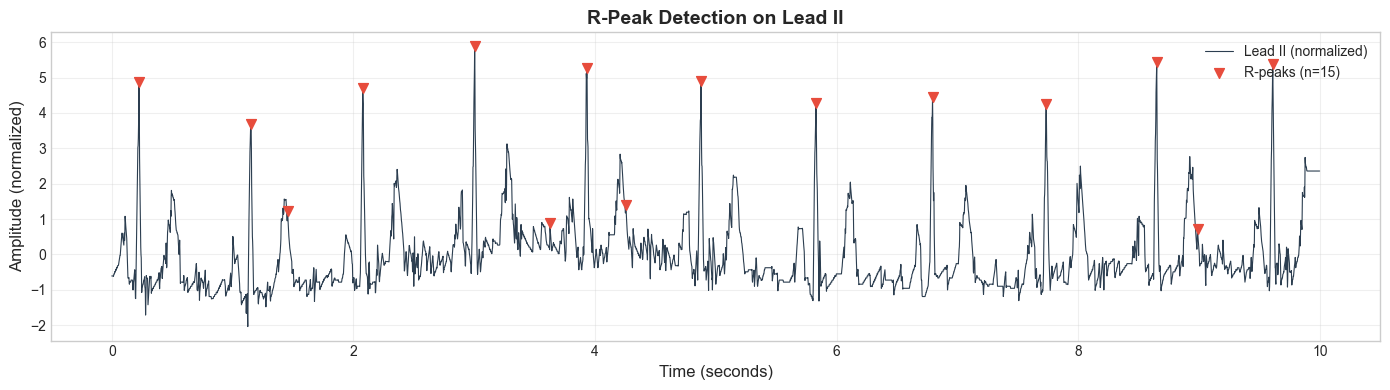


✓ R-peak detection working correctly


In [29]:
# ============================================================================
# TEST R-PEAK DETECTION
# ============================================================================

# Load and normalize a sample ECG
sample_ecg = load_ecg_waveform(df.iloc[0]['filename_hr'], CONFIG['data_path'])
normalized_ecg = normalize_ecg(sample_ecg)

# Use Lead II (index 1) for R-peak detection - best lead for this purpose
lead_ii = normalized_ecg[:, 1]

# Detect R-peaks
r_peaks = detect_r_peaks(lead_ii, fs=CONFIG['sampling_rate'])
hr_info = calculate_heart_rate(r_peaks, fs=CONFIG['sampling_rate'])

print(f"\n📊 R-Peak Detection Results:")
print(f"   Number of R-peaks detected: {len(r_peaks)}")
print(f"   Expected beats (10 sec): ~{10 * 60/60}-{10 * 200/60} (at 60-200 BPM)")
print(f"\n💓 Heart Rate Analysis:")
print(f"   Mean HR: {hr_info['mean_hr']:.1f} BPM")
print(f"   Min HR:  {hr_info['min_hr']:.1f} BPM")
print(f"   Max HR:  {hr_info['max_hr']:.1f} BPM")

# Visualize R-peak detection
fig, ax = plt.subplots(figsize=(14, 4))
time = np.arange(len(lead_ii)) / CONFIG['sampling_rate']

ax.plot(time, lead_ii, color='#2c3e50', linewidth=0.8, label='Lead II (normalized)')
ax.scatter(r_peaks / CONFIG['sampling_rate'], lead_ii[r_peaks], 
           color='#e74c3c', s=50, marker='v', zorder=5, label=f'R-peaks (n={len(r_peaks)})')

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Amplitude (normalized)', fontsize=12)
ax.set_title('R-Peak Detection on Lead II', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ R-peak detection working correctly")

---

## Section 5 Summary

### What we accomplished:
1. **ECG Normalization** - Z-score normalization per lead (zero mean, unit variance)
2. **Bandpass Filter** - Optional 0.5-40 Hz filter for noisy signals
3. **R-Peak Detection** - Using scipy.signal.find_peaks with adaptive thresholds
4. **Heart Rate Calculation** - Converting RR intervals to BPM

### Key functions created:
| Function | Purpose | Output |
|----------|---------|--------|
| `normalize_ecg()` | Standardize ECG amplitude | (5000, 12) normalized array |
| `light_filter_ecg()` | Remove noise (optional) | (5000, 12) filtered array |
| `detect_r_peaks()` | Find heartbeat locations | Array of sample indices |
| `calculate_heart_rate()` | Compute HR from peaks | Dict with mean/min/max HR |

### Signal processing notes:
- **Lead II** is used for R-peak detection (clearest R-wave morphology)
- **Minimum distance** constraint prevents false positives (max 200 BPM)
- **Adaptive threshold** handles varying signal amplitudes
- **PTB-XL signals are clean** - heavy filtering not needed

### Next: Section 6 - Feature Extraction
We'll extract HRV features and statistical features from each ECG.

---